In [1]:
from keras.models import Sequential

import cv2 
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from joblib import Parallel, delayed
import multiprocessing
import copy
from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping 
from keras.applications import InceptionResNetV2
from keras import layers
from keras import models
from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import os
import matplotlib
import matplotlib.pyplot as plt

import scipy.misc


Using TensorFlow backend.
C:\Users\sahan\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:


def jaccard(y_true, y_pred, smooth=1.):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def lossfunc(y_true, y_pred):
    return - 1 * jaccard(y_true, y_pred)
    # return - 0.7 * jaccard(y_true, y_pred) - 0.3 * dice(y_true, y_pred)


def unet(IMG_WIDTH=128,IMG_HEIGHT=128,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(axis=3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(Dropout(0.2)(conv4))
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization(axis=3)(conv5)
    
    middle = Dropout(0.2)(conv5)
    

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D()(middle)) 
    up6 = BatchNormalization(axis=3)(up6) 
    concat6 = concatenate([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = BatchNormalization(axis=3)(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization(axis=3)(conv6)
   
   
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D()(conv6))
    up7 = BatchNormalization(axis=3)(up7)
    concat7 = concatenate([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = BatchNormalization(axis=3)(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization(axis=3)(conv7)

    
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D()(conv7)) 
    up8 = BatchNormalization(axis=3)(up8)
    concat8 = concatenate([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = BatchNormalization(axis=3)(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization(axis=3)(conv8)

    
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D()(conv8)) 
    up9 = BatchNormalization(axis=3)(up9)
    concat9 = concatenate([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = BatchNormalization(axis=3)(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization(axis=3)(conv9)

    
    conv10 = Conv2D(1, 1, activation='sigmoid', padding='same')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True),loss='categorical_crossentropy', metrics=[jaccard])

    return model

semgmodel = unet()


semgmodel = load_model('test1.h5', custom_objects={'jaccard': jaccard})


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [18]:
image_ids = next(os.walk('data_task3/image/test_128/'))[2]

X_train = np.zeros((len(image_ids), 128, 128,3), dtype=np.float32)

for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path ='data_task3/image/test_128/'
    img = cv2.imread(path + id_)
    X_train[n] = img

In [19]:
preds_train = (semgmodel.predict(X_train, verbose=1)*255).astype(np.uint8)



10015/10015 [==============================] - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA

16384
[[0 0 0 ... 1 2 2]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [2 1 0 ... 0 0 0]
 [2 1 0 ... 0 0 1]
 [3 2 1 ... 0 1 2]]


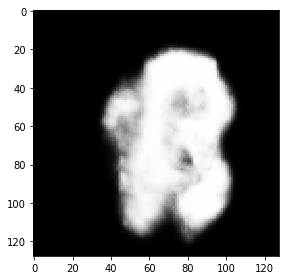

In [38]:
seg = preds_train
x = np.squeeze(preds_train[1])
print(x.size)
print(np.squeeze(preds_train[1]))
imshow(np.squeeze(preds_train[1]))
plt.show()

In [39]:
image_ids[1]

'ISIC_0024307.jpg'

In [43]:
for i in range(len(image_ids)):
    x = np.squeeze(seg[i])
    array= scipy.misc.imresize(x, size =(299,299), interp= 'bicubic', mode=None)
    scipy.misc.imsave('data_task3/image/seg_299/'+image_ids[i], array)

C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()
C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [2]:
df = pd.read_csv('data_task3/gt.csv')

df['image'] = df['image'].astype(str)+'.jpg'
df.head()
df.iloc[5,2]
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
image_ids = next(os.walk('data_task3/image/test_299/'))[2]
len(image_ids)


10015

In [4]:
indexes = []
for i in range(1, 4000):
        if df.iloc[i,2 ] == 1:
            
            os.remove('data_task3/image/test_299/'+df.iloc[i,0])
            indexes.append(i)


In [5]:
for i in indexes:
    df= df.drop([i])

In [6]:

df.sum(axis = 0)


image    ISIC_0024306.jpgISIC_0024310.jpgISIC_0024312.j...
MEL                                                   1113
NV                                                    3958
BCC                                                    514
AKIEC                                                  327
BKL                                                   1099
DF                                                     115
VASC                                                   142
dtype: object

In [7]:
image_ids = next(os.walk('data_task3/image/test_299/'))[2]
len(image_ids)
class_weight = {0: 2,
                1: 1,
                2: 10,
               3:12,
               4:5,
               5:50,
               6:40}
class_weight2 = {0: 1,
                1: 2,
                2: 20,
               3:31,
               4:15,
               5:100,
               6:100}

In [8]:
columns = ['MEL', 'NV', 'BCC','AKIEC', 'BKL', 'DF','VASC']

In [9]:
datagen_valid =ImageDataGenerator(rescale =1./255.)

In [10]:
datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen=ImageDataGenerator(rescale=1./255.)


train_generator = datagen.flow_from_dataframe(dataframe = df[:6500],
                            directory = 'C://Users//sahan//ipthw//Melanoma_segmentation//data_task3//image//test_299', x_col = 'image',
                            y_col = columns,seed = 42, shuffle = True, class_mode = 'other',
                            target_size = (299, 299))


Found 6500 validated image filenames.


In [11]:
valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[6500:],
directory='C://Users//sahan//ipthw//Melanoma_segmentation//data_task3//image//test_299',
x_col="image",
y_col=columns,
batch_size=32,
seed=42,
shuffle=True,
class_mode="other",
target_size=(299,299))



Found 768 validated image filenames.


In [12]:
conv_base = InceptionResNetV2(include_top=False , weights='imagenet',  input_shape=(299,299, 3))


Instructions for updating:
Colocations handled automatically by placer.


In [16]:


model = Sequential()
model.add(conv_base)
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2, 2)) )
    
model.add(Conv2D(512, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(512, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))

    
model.add(Conv2D(1024, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(1024, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))



model.add(Conv2D(2048, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(2048, 3, activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))


    
model.add(Flatten())


model.add(Dense(4096, activation = 'relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99)) 
model.add(Dropout(0.5))
model.add(Dense(4096, activation = 'relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99)) 



model.add(Dense(2048, activation = 'relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99)) 
model.add(Dropout(0.4))
model.add(Dense(2048, activation = 'relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99)) 
model.add(Dropout(0.4))

model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99)) 
model.add(Dropout(0.4))
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99)) 
model.add(Dropout(0.3))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization(axis=-1, momentum=0.99)) 
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(7, activation = 'softmax'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
print('number trainabke weights before freezing : ', len(model.trainable_weights))

number trainabke weights before freezing :  570


In [18]:
conv_base.trainable = False
print('number trainabke weights after freezing : ', len(model.trainable_weights))

number trainabke weights after freezing :  82


In [19]:

lr_scheduler =ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=8)
checkpoint = ModelCheckpoint('task3_keras_1.h5', monitor  = 'val_acc' , verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='data_task3/logs', write_graph=True, write_images=True)

In [20]:
model.compile(optimizers.rmsprop(lr=0.01),loss="categorical_crossentropy",metrics=["accuracy"])


In [21]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


In [22]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    #class_weight=class_weight,
                    callbacks=[early_stopping,checkpoint,tensorboard],
                    epochs=20
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
203/203 [==============================] - ETA: 29:54 - loss: 0.5769 - acc: 0.82 - ETA: 15:15 - loss: 0.6041 - acc: 0.83 - ETA: 10:22 - loss: 0.7497 - acc: 0.84 - ETA: 7:55 - loss: 0.8471 - acc: 0.8404 - ETA: 6:27 - loss: 1.0799 - acc: 0.822 - ETA: 5:29 - loss: 1.2192 - acc: 0.817 - ETA: 4:47 - loss: 1.2499 - acc: 0.808 - ETA: 4:15 - loss: 1.1954 - acc: 0.815 - ETA: 3:50 - loss: 1.1250 - acc: 0.820 - ETA: 3:31 - loss: 1.0810 - acc: 0.821 - ETA: 3:14 - loss: 1.0514 - acc: 0.822 - ETA: 3:01 - loss: 1.0238 - acc: 0.822 - ETA: 2:49 - loss: 1.0086 - acc: 0.825 - ETA: 2:40 - loss: 0.9761 - acc: 0.826 - ETA: 2:31 - loss: 0.9688 - acc: 0.827 - ETA: 2:23 - loss: 0.9245 - acc: 0.832 - ETA: 2:17 - loss: 0.9087 - acc: 0.834 - ETA: 2:11 - loss: 0.8914 - acc: 0.835 - ETA: 2:05 - loss: 0.8761 - acc: 0.836 - ETA: 2:00 - loss: 0.8579 - acc: 0.838 - ETA: 1:56 - loss: 0.8596 - acc: 0.839 - ETA: 1:52 - loss: 0.8800 - acc: 0.838 - ETA: 1:48 - loss:


Epoch 00001: val_acc improved from -inf to 0.87984, saving model to task3_keras_1.h5
Epoch 2/20
203/203 [==============================] - ETA: 3:25 - loss: 0.2868 - acc: 0.857 - ETA: 2:05 - loss: 0.3187 - acc: 0.859 - ETA: 1:38 - loss: 0.3331 - acc: 0.855 - ETA: 1:24 - loss: 0.3395 - acc: 0.856 - ETA: 1:16 - loss: 0.3306 - acc: 0.859 - ETA: 1:11 - loss: 0.3265 - acc: 0.862 - ETA: 1:07 - loss: 0.3322 - acc: 0.861 - ETA: 1:04 - loss: 0.3294 - acc: 0.861 - ETA: 1:01 - loss: 0.3274 - acc: 0.858 - ETA: 59s - loss: 0.3270 - acc: 0.860 - ETA: 57s - loss: 0.3316 - acc: 0.85 - ETA: 56s - loss: 0.3304 - acc: 0.85 - ETA: 55s - loss: 0.3308 - acc: 0.85 - ETA: 54s - loss: 0.3288 - acc: 0.85 - ETA: 53s - loss: 0.3284 - acc: 0.85 - ETA: 52s - loss: 0.3282 - acc: 0.85 - ETA: 51s - loss: 0.3274 - acc: 0.85 - ETA: 50s - loss: 0.3268 - acc: 0.85 - ETA: 49s - loss: 0.3274 - acc: 0.86 - ETA: 49s - loss: 0.3262 - acc: 0.86 - ETA: 48s - loss: 0.3248 - acc: 0.86 - ETA: 48s - loss: 0.3254 - acc: 0.86 - ETA: 

203/203 [==============================] - ETA: 46s - loss: 0.3413 - acc: 0.86 - ETA: 46s - loss: 0.3126 - acc: 0.87 - ETA: 39s - loss: 0.3120 - acc: 0.88 - ETA: 40s - loss: 0.3113 - acc: 0.87 - ETA: 41s - loss: 0.3151 - acc: 0.87 - ETA: 42s - loss: 0.3078 - acc: 0.87 - ETA: 42s - loss: 0.3106 - acc: 0.87 - ETA: 42s - loss: 0.3066 - acc: 0.87 - ETA: 42s - loss: 0.3096 - acc: 0.87 - ETA: 42s - loss: 0.3089 - acc: 0.87 - ETA: 42s - loss: 0.3083 - acc: 0.87 - ETA: 42s - loss: 0.3056 - acc: 0.87 - ETA: 42s - loss: 0.2998 - acc: 0.87 - ETA: 42s - loss: 0.2979 - acc: 0.87 - ETA: 42s - loss: 0.2988 - acc: 0.87 - ETA: 42s - loss: 0.3008 - acc: 0.87 - ETA: 41s - loss: 0.2988 - acc: 0.88 - ETA: 41s - loss: 0.2991 - acc: 0.88 - ETA: 41s - loss: 0.3001 - acc: 0.88 - ETA: 41s - loss: 0.3001 - acc: 0.88 - ETA: 43s - loss: 0.3034 - acc: 0.87 - ETA: 44s - loss: 0.3028 - acc: 0.87 - ETA: 45s - loss: 0.3001 - acc: 0.88 - ETA: 46s - loss: 0.3013 - acc: 0.88 - ETA: 47s - loss: 0.3029 - acc: 0.87 - ETA: 47

203/203 [==============================] - ETA: 46s - loss: 0.2738 - acc: 0.88 - ETA: 46s - loss: 0.2868 - acc: 0.88 - ETA: 46s - loss: 0.2948 - acc: 0.88 - ETA: 46s - loss: 0.2893 - acc: 0.88 - ETA: 41s - loss: 0.2731 - acc: 0.89 - ETA: 42s - loss: 0.2809 - acc: 0.88 - ETA: 42s - loss: 0.2775 - acc: 0.89 - ETA: 42s - loss: 0.2774 - acc: 0.89 - ETA: 42s - loss: 0.2878 - acc: 0.88 - ETA: 42s - loss: 0.2845 - acc: 0.89 - ETA: 42s - loss: 0.2807 - acc: 0.89 - ETA: 42s - loss: 0.2802 - acc: 0.89 - ETA: 42s - loss: 0.2759 - acc: 0.89 - ETA: 42s - loss: 0.2775 - acc: 0.89 - ETA: 42s - loss: 0.2774 - acc: 0.89 - ETA: 42s - loss: 0.2768 - acc: 0.89 - ETA: 41s - loss: 0.2781 - acc: 0.89 - ETA: 41s - loss: 0.2785 - acc: 0.89 - ETA: 41s - loss: 0.2772 - acc: 0.89 - ETA: 42s - loss: 0.2832 - acc: 0.88 - ETA: 43s - loss: 0.2839 - acc: 0.88 - ETA: 44s - loss: 0.2838 - acc: 0.88 - ETA: 46s - loss: 0.2864 - acc: 0.88 - ETA: 47s - loss: 0.2883 - acc: 0.88 - ETA: 48s - loss: 0.2883 - acc: 0.88 - ETA: 48

203/203 [==============================] - ETA: 47s - loss: 0.2422 - acc: 0.90 - ETA: 47s - loss: 0.2789 - acc: 0.89 - ETA: 47s - loss: 0.2592 - acc: 0.90 - ETA: 46s - loss: 0.2611 - acc: 0.90 - ETA: 46s - loss: 0.2544 - acc: 0.90 - ETA: 46s - loss: 0.2518 - acc: 0.90 - ETA: 42s - loss: 0.2444 - acc: 0.90 - ETA: 43s - loss: 0.2553 - acc: 0.89 - ETA: 43s - loss: 0.2601 - acc: 0.89 - ETA: 43s - loss: 0.2585 - acc: 0.89 - ETA: 44s - loss: 0.2548 - acc: 0.89 - ETA: 43s - loss: 0.2531 - acc: 0.90 - ETA: 43s - loss: 0.2496 - acc: 0.90 - ETA: 43s - loss: 0.2479 - acc: 0.90 - ETA: 43s - loss: 0.2520 - acc: 0.90 - ETA: 43s - loss: 0.2548 - acc: 0.89 - ETA: 42s - loss: 0.2551 - acc: 0.89 - ETA: 42s - loss: 0.2547 - acc: 0.89 - ETA: 42s - loss: 0.2522 - acc: 0.90 - ETA: 42s - loss: 0.2518 - acc: 0.90 - ETA: 43s - loss: 0.2510 - acc: 0.90 - ETA: 45s - loss: 0.2517 - acc: 0.90 - ETA: 46s - loss: 0.2513 - acc: 0.90 - ETA: 47s - loss: 0.2533 - acc: 0.90 - ETA: 48s - loss: 0.2534 - acc: 0.90 - ETA: 49

203/203 [==============================] - ETA: 48s - loss: 0.1983 - acc: 0.91 - ETA: 48s - loss: 0.2094 - acc: 0.92 - ETA: 47s - loss: 0.2282 - acc: 0.91 - ETA: 47s - loss: 0.2508 - acc: 0.90 - ETA: 46s - loss: 0.2455 - acc: 0.90 - ETA: 46s - loss: 0.2664 - acc: 0.90 - ETA: 45s - loss: 0.2644 - acc: 0.90 - ETA: 45s - loss: 0.2651 - acc: 0.89 - ETA: 42s - loss: 0.2635 - acc: 0.90 - ETA: 43s - loss: 0.2634 - acc: 0.90 - ETA: 43s - loss: 0.2653 - acc: 0.90 - ETA: 43s - loss: 0.2617 - acc: 0.90 - ETA: 43s - loss: 0.2609 - acc: 0.90 - ETA: 43s - loss: 0.2611 - acc: 0.90 - ETA: 42s - loss: 0.2580 - acc: 0.90 - ETA: 42s - loss: 0.2575 - acc: 0.90 - ETA: 42s - loss: 0.2564 - acc: 0.90 - ETA: 42s - loss: 0.2546 - acc: 0.90 - ETA: 42s - loss: 0.2556 - acc: 0.90 - ETA: 42s - loss: 0.2556 - acc: 0.90 - ETA: 44s - loss: 0.2534 - acc: 0.90 - ETA: 45s - loss: 0.2544 - acc: 0.90 - ETA: 46s - loss: 0.2574 - acc: 0.90 - ETA: 47s - loss: 0.2578 - acc: 0.90 - ETA: 48s - loss: 0.2571 - acc: 0.90 - ETA: 49

203/203 [==============================] - ETA: 46s - loss: 0.2210 - acc: 0.91 - ETA: 46s - loss: 0.2039 - acc: 0.92 - ETA: 45s - loss: 0.2215 - acc: 0.91 - ETA: 45s - loss: 0.2344 - acc: 0.90 - ETA: 45s - loss: 0.2294 - acc: 0.91 - ETA: 44s - loss: 0.2302 - acc: 0.91 - ETA: 44s - loss: 0.2271 - acc: 0.91 - ETA: 44s - loss: 0.2298 - acc: 0.91 - ETA: 44s - loss: 0.2386 - acc: 0.90 - ETA: 43s - loss: 0.2397 - acc: 0.90 - ETA: 41s - loss: 0.2362 - acc: 0.90 - ETA: 41s - loss: 0.2378 - acc: 0.90 - ETA: 41s - loss: 0.2408 - acc: 0.90 - ETA: 41s - loss: 0.2378 - acc: 0.90 - ETA: 41s - loss: 0.2411 - acc: 0.90 - ETA: 41s - loss: 0.2453 - acc: 0.90 - ETA: 40s - loss: 0.2460 - acc: 0.90 - ETA: 40s - loss: 0.2459 - acc: 0.90 - ETA: 40s - loss: 0.2471 - acc: 0.90 - ETA: 41s - loss: 0.2452 - acc: 0.90 - ETA: 42s - loss: 0.2429 - acc: 0.90 - ETA: 43s - loss: 0.2453 - acc: 0.90 - ETA: 44s - loss: 0.2462 - acc: 0.90 - ETA: 45s - loss: 0.2453 - acc: 0.90 - ETA: 46s - loss: 0.2453 - acc: 0.90 - ETA: 47

203/203 [==============================] - ETA: 46s - loss: 0.2477 - acc: 0.90 - ETA: 46s - loss: 0.2336 - acc: 0.90 - ETA: 46s - loss: 0.2403 - acc: 0.90 - ETA: 45s - loss: 0.2328 - acc: 0.90 - ETA: 45s - loss: 0.2343 - acc: 0.90 - ETA: 45s - loss: 0.2470 - acc: 0.90 - ETA: 44s - loss: 0.2453 - acc: 0.90 - ETA: 44s - loss: 0.2464 - acc: 0.90 - ETA: 44s - loss: 0.2490 - acc: 0.90 - ETA: 44s - loss: 0.2510 - acc: 0.90 - ETA: 43s - loss: 0.2503 - acc: 0.90 - ETA: 43s - loss: 0.2495 - acc: 0.90 - ETA: 41s - loss: 0.2421 - acc: 0.91 - ETA: 41s - loss: 0.2463 - acc: 0.91 - ETA: 41s - loss: 0.2452 - acc: 0.91 - ETA: 41s - loss: 0.2541 - acc: 0.90 - ETA: 41s - loss: 0.2539 - acc: 0.90 - ETA: 40s - loss: 0.2549 - acc: 0.90 - ETA: 40s - loss: 0.2544 - acc: 0.90 - ETA: 41s - loss: 0.2523 - acc: 0.90 - ETA: 43s - loss: 0.2539 - acc: 0.90 - ETA: 44s - loss: 0.2521 - acc: 0.90 - ETA: 45s - loss: 0.2516 - acc: 0.90 - ETA: 46s - loss: 0.2487 - acc: 0.90 - ETA: 47s - loss: 0.2478 - acc: 0.90 - ETA: 47

In [23]:
image_ids = next(os.walk('data_task3/image/test_299/'))[2]
X_eval = np.zeros((len(image_ids), 299, 299,3), dtype=np.float32)
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path ='data_task3/image/test_299/'
    img = cv2.imread(path + id_)
    X_eval[n] = img


In [24]:
Inception_model = load_model('task3_keras_1.h5')
preds_inception = Inception_model.predict(X_eval, verbose=1)

C:\Users\sahan\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


7268/7268 [==============================] - ETA: 1:19:3 - ETA: 39:55  - ETA: 26:4 - ETA: 20:0 - ETA: 16:0 - ETA: 13:2 - ETA: 11:3 - ETA: 10:1 - ETA: 9:0 - ETA: 8: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 52 - ETA

In [25]:
def get_metrics(predictions,targets):
    # Calculate metrics
    # Accuarcy
    acc = np.mean(np.equal(np.argmax(predictions,1),np.argmax(targets,1)))
    # Confusion matrix
    conf = confusion_matrix(np.argmax(targets,1),np.argmax(predictions,1))     
    # Class weighted accuracy
    wacc = conf.diagonal()/conf.sum(axis=1)  
    # Auc
    fpr = {}
    tpr = {}
    roc_auc = np.zeros([7])
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(targets[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])       
    # F1 Score
    f1 = f1_score(np.argmax(predictions,1),np.argmax(targets,1),average='weighted')        
    # Print
    print("Accuracy:",acc)
    print("F1-Score:",f1)
    print("WACC:",wacc)
    print("Mean WACC:",np.mean(wacc))
    print("AUC:",roc_auc)
    print("Mean Auc:",np.mean(roc_auc))        
    return 

In [26]:
preds_inception.shape

(7268, 7)

In [27]:
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ISIC_0024312.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,ISIC_0024313.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ISIC_0024315.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:

targets = df.iloc[:,1:].values
targets.shape

(7268, 7)

In [29]:
(targets.sum(axis =0))

array([1113., 3958.,  514.,  327., 1099.,  115.,  142.])

In [30]:
preds_inception
preds = pd.DataFrame({'mel':preds_inception[:,0],'nv':preds_inception[:,1],'bcc':preds_inception[:,2], 'akiec':preds_inception[:,3], 'bkl':preds_inception[:,4], 'df':preds_inception[:,5] ,'VASC':preds_inception[:,6]})
preds.sum(axis = 0)

mel        18.204052
nv       7222.953125
bcc         5.822194
akiec       3.380983
bkl        14.248933
df          1.445953
VASC        1.946773
dtype: float32

In [31]:
get_metrics(preds_inception, targets)

C:\Users\sahan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy: 0.5440286186020914
F1-Score: 0.7031651573928797
WACC: [0.         0.99823143 0.         0.         0.00272975 0.
 0.        ]
Mean WACC: 0.1429944549053243
AUC: [0.67942133 0.52220032 0.47747768 0.47847762 0.63074759 0.39303485
 0.49977468]
Mean Auc: 0.5258762953364033
